<a href="https://colab.research.google.com/github/eborsi/BIOL468/blob/master/FDvsUD_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing libraries**

In [0]:
from os.path import dirname, join 
import time
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

#import tools for data visualization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#import classifiers and tools from sci-kit learn library
from sklearn import datasets, svm, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, roc_curve, recall_score, precision_score, make_scorer, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier

#import libraries for CNN
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [11]:
#import and mount google drive (where .mat files are located)
from google.colab import drive, files
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#**Helper functions**
##For loading, pre-processing and visualizing data


> Contains the functions:

*   matToDataframe()
*   dfToNumpy()
*   load_matfiles()
*   split_TrainTest()
*   list_motifs_from_dict()
*   make_PCA_plot()
*   make_tSNE_plot()



In [0]:
def matToDataframe(matfile, filename):
  DataMat = matfile['TS_DataMat']
  CatMat = matfile['TimeSeries']['Group']
  y_column = np.zeros(CatMat.shape[0]).astype(int)
  for i in range(CatMat.shape[0]):
    if int(CatMat[i][0][0][0])==2:
      y_column[i] = 1
    else:
      y_column[i] = 0
  #print(DataMat.shape, y_column.shape)
  op_IDs_mat = matfile['Operations']['ID']
  op_IDs = [str(op_IDs_mat[i][0][0][0]) for i in range(op_IDs_mat.shape[0])]
  df = pd.DataFrame.from_dict(DataMat)
  df.columns = op_IDs
  df['y'] = y_column
  df['bird_motif'] = filename
  return df

def dfToNumpy(df):
  X = np.array(df.iloc[:,:-2])
  Y = np.array(df['y'])
  IDs = np.array(df['bird_motif'])
  return X,Y,IDs

def load_matfiles(motifs_dict):
  matFiles = []
  filenames = []
  for bird in motifs_dict.keys():
    for motif in motifs_dict[bird]:
      mat_filename = 'HCTSA_' + bird + '_' + motif + '_N.mat'
      mat_filepath = join(data_dir, bird, motif, mat_filename)
      matFile = scipy.io.loadmat(mat_filepath)
      matFiles.append(matFile)
      filenames.append(''+ bird + '_' + motif)
  return zip(matFiles, filenames)

def split_TrainTest(df, motifs_dict, test_bird, test_motif):
  test_bird_motif = ''+test_bird+'_'+test_motif
  df_test = df.loc[df['bird_motif'] == test_bird_motif]
  df_train = df.copy()
  for motif in motifs_dict[test_bird]:
    motif_ID = ''+test_bird+'_'+motif
    df_train = df_train.drop(df_train[df_train['bird_motif']==motif_ID].index)
  X_train, y_train, IDs_train = dfToNumpy(df_train)
  X_test, y_test, IDs_test = dfToNumpy(df_test)
  return X_train, y_train, X_test, y_test, IDs_train, IDs_test

def split_TrainTest_indiv(df, motifs_dict, test_bird, test_motif):
  bird_motifs = motifs_dict[test_bird]
  df_train = pd.DataFrame()
  for motif in bird_motifs:
    bird_motif_tag = ''+test_bird+'_'+motif
    df_motif = df.loc[df['bird_motif'] == bird_motif_tag]
    if (motif==test_motif):
      df_test = df_motif
    else:
      df_train = pd.concat([df_train,df_motif])
  X_train, y_train, IDs_train = dfToNumpy(df_train)
  X_test, y_test, IDs_test = dfToNumpy(df_test)
  return X_train, y_train, X_test, y_test, IDs_train, IDs_test  

def list_motifs_from_dict(motifs_dict):
  list_motifs = []
  for bird in motifs_dict:
    for motif in motifs_dict[bird]:
      bird_motif = ''+bird+'_'+motif
      list_motifs.append(bird_motif)
  return list_motifs

def make_PCA_plot(df, color_per_motif = True):
  X,y,IDs = dfToNumpy(df)
  y_label = np.copy(y).astype(str)
  y_label[y_label == '0'] = 'UD'
  y_label[y_label == '1'] = 'FD'
  nb_motifs = len(np.unique(IDs))
  pca = PCA(n_components=2)
  pca_result = pca.fit_transform(X)
  #df['pca-one'] = pca_result[:,0]
  #df['pca-two'] = pca_result[:,1] 
  print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

  plt.figure(figsize=(8,5))
  ax = sns.scatterplot(
    x=pca_result[:,0], y= pca_result[:,1],
    style=y_label,
    hue=IDs,
    palette=sns.color_palette("Paired",nb_motifs), 
    legend="full",
    alpha=0.5,
    #ax=ax
  )
  legend = plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
  ax.set(xlabel='Principal component 1', ylabel='Principal component 2')
  plt.title('PCA on whole dataset (colour-coded by motif)')
  plt.savefig('PCA_incomplete_colors.png', bbox_extra_artists=(legend,), bbox_inches='tight')
  files.download('PCA_incomplete_colors.png')


  plt.figure(figsize=(8,5))
  ax2 = sns.scatterplot(
      x=pca_result[:,0], y=pca_result[:,1],
      style=y_label,
      hue=y_label,
      #palette=sns.color_palette("hls", 2),
      legend="full",
      alpha=0.5,
      
  )
  legend2 = plt.legend(loc='best', ncol=1)
  ax2.set(xlabel='Principal component 1', ylabel='Principal component 2')
  plt.title('PCA on whole dataset')
  plt.savefig('PCA_plot.png',  bbox_inches='tight')
  files.download('PCA_plot.png')

def make_tSNE_plot(df):
  X,y,IDs = dfToNumpy(df)
  y_label = np.copy(y).astype(str)
  y_label[y_label == '0'] = 'UD'
  y_label[y_label == '1'] = 'FD'
  nb_motifs = len(np.unique(IDs))
  time_start = time.time()
  pca_50 = PCA(n_components=50)
  pca_result_50 = pca_50.fit_transform(X)
  print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
  tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
  tsne_pca_results = tsne.fit_transform(pca_result_50)
  print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

  plt.figure(figsize=(8,5))
  ax = sns.scatterplot(
    x=tsne_pca_results[:,0], y= tsne_pca_results[:,1],
    style=y_label,
    hue=IDs,
    palette=sns.color_palette("Paired",nb_motifs), 
    legend="full",
    alpha=0.5,
    #ax=ax
  )
  legend = plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
  ax.set(xlabel='Dimension 1', ylabel='Dimension 2')
  plt.title('t-SNE on whole dataset (colour-coded by motif)')
  plt.savefig('tSNE_plot_colors.png', bbox_extra_artists=(legend,), bbox_inches='tight')
  files.download('tSNE_plot_colors.png')


  plt.figure(figsize=(8,5))
  ax2 = sns.scatterplot(
      x=tsne_pca_results[:,0], y= tsne_pca_results[:,1],
      style=y_label,
      hue=y_label,
      #palette=sns.color_palette("hls", 2),
      legend="full",
      alpha=0.5,
      
  )
  legend2 = plt.legend(loc='best', ncol=1)
  ax2.set(xlabel='Dimension 1', ylabel='Dimension 2')
  plt.title('t-SNE on whole dataset')
  plt.savefig('tSNE_plot.png',  bbox_inches='tight')
  files.download('tSNE_plot.png')



In [0]:
def split_TrainTest_indiv(df, motifs_dict, test_bird, test_motif):
  #build train set:
  bird_motifs = motifs_dict[test_bird]
  df_train = pd.DataFrame()
  for motif in bird_motifs:
    print(motif)
    bird_motif_tag = ''+test_bird+'_'+motif
    df_motif = df.loc[df['bird_motif'] == bird_motif_tag]
    #print(df_motif.head())
    if (motif==test_motif):
      df_test = df_motif
    else:
      df_train = pd.concat([df_train,df_motif])
  X_train, y_train, IDs_train = dfToNumpy(df_train)
  X_test, y_test, IDs_test = dfToNumpy(df_test)
  return X_train, y_train, X_test, y_test, IDs_train, IDs_test 

#**Loading the data**

First 5 rows of the complete dataframe: 
           1         2         4  ...      7873  y          bird_motif
0  0.281693  0.430784  0.311264  ...  0.092443  1  bk109-re22or7_abcd
1  0.141843  1.000000  0.820295  ...  0.900822  1  bk109-re22or7_abcd
2  0.221615  0.287441  0.080510  ...  0.022543  1  bk109-re22or7_abcd
3  0.341237  0.609037  0.185116  ...  0.712741  1  bk109-re22or7_abcd
4  0.135395  0.690432  0.080510  ...  0.707577  1  bk109-re22or7_abcd

[5 rows x 5954 columns]
Explained variation per principal component: [0.10420491 0.0732937 ]
Cumulative explained variation for 50 principal components: 0.5719007770673374
t-SNE done! Time elapsed: 2.946685552597046 seconds
            1         2         4  ...      7873  y          bird_motif
0    0.281693  0.430784  0.311264  ...  0.092443  1  bk109-re22or7_abcd
1    0.141843  1.000000  0.820295  ...  0.900822  1  bk109-re22or7_abcd
2    0.221615  0.287441  0.080510  ...  0.022543  1  bk109-re22or7_abcd
3    0.341237  0.609037  

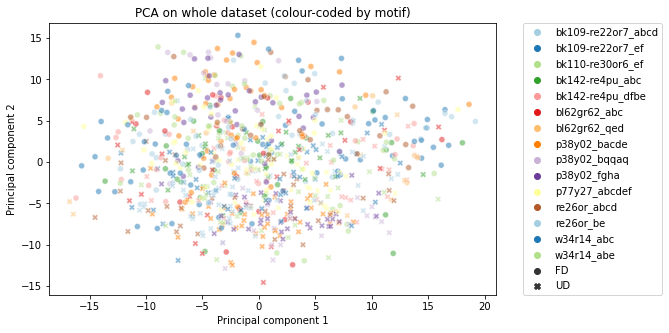

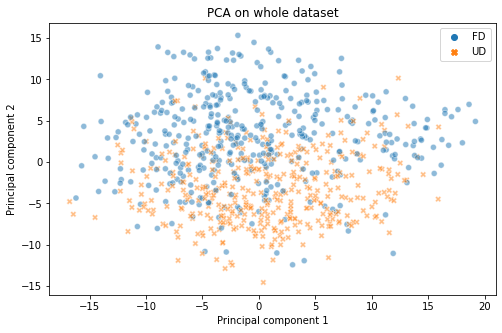

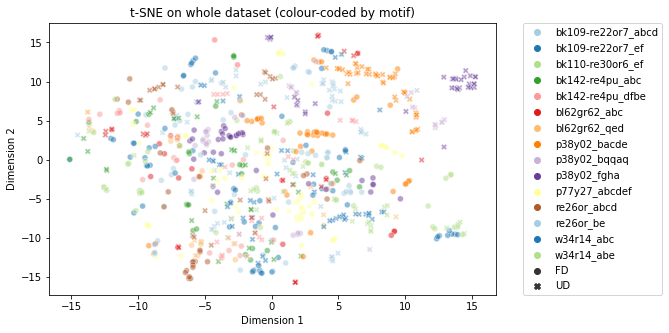

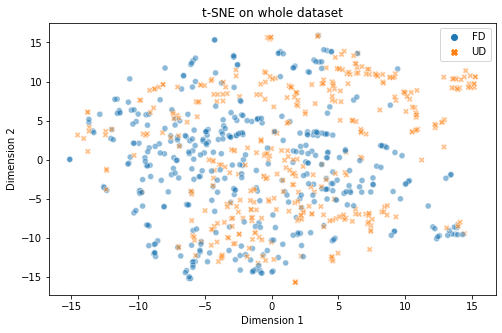

In [48]:
# loading .mat files for all birds & motifs
data_dir = '/content/drive/My Drive/BIOL 468/HCTSA mat files' #change to directory where mat files are stored
#python dictionary representing the dataset, formatted as such : {'bird1_ID':['motif1',...,['motifn'], 'bird2_ID':['motif1',...,['motifn']}
motifs_dict = {'bk109-re22or7': ['abcd','ef'],
               'bk110-re30or6': ['ef'], 
               'bk142-re4pu': ['abc','dfbe'],
               'bl62gr62': ['abc','qed'],
               'p38y02': ['bacde','bqqaq','fgha'],
               'p77y27': ['abcdef'],
               're26or': ['abcd','be'],
               'w34r14': ['abc','abe']
              }
#load_matfiles() takes a dictionary of motifs as argument 
#the data should be stored in this architecture: data_dir/bird_ID/motif/HCTSA_*.mat
#load_matfiles() returns an array of tuples of the form (mat file, name of file)
matFiles = load_matfiles(motifs_dict)
#matToDataframe() loads the Time Series data from the HCTSA_*.mat files into Pandas dataframes
#and attaches the encoded labels ('UD'->0 and 'FD'->1) and the dataset tag (birdID_motif)
dataframes = [matToDataframe(matfile,filename) for (matfile,filename) in matFiles]
#pd.concat() concatenates all the dataframes for individual motifs into a single large dataframe
concat_df = pd.concat(dataframes, ignore_index=True, sort=False).dropna(axis=1)

print("First 5 rows of the complete dataframe: \n", concat_df.head())

make_PCA_plot(concat_df)  #generates a PCA plot with n=2 principal components from the concatenated dataframe to visualize the data
make_tSNE_plot(concat_df)  #generates a plot of the data after a PCA (n=50) and a t-SNE (n=2 dimensions)

print(concat_df)

# **Hyperparameter optimization**

##Optimization of hyperparameters using exhaustive search approach (or gridsearch) for different binary classifiers:
*   LinearSVC
*   SVC
*   Logistic Regression 
*   Naive Bayes
*   Decision Tree (no bagging)
*   Decision Tree (with bagging)
*   AdaBoost
*   Random Forest
*   Stochastic Gradient Descent (SGD) classifiers





##Linear SVC 

In [0]:
# MODEL: Linear SVC #
LinSVM_param_grid = [   {'C':[0.001, 0.01, 0.1, 1, 5, 10], 'max_iter': [100, 1000, 10000]}
                    ]
print("# LinearSVC: Tuning hyper-parameters for accuracy")
print()
scores = ['accuracy','precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LinearSVC(), LinSVM_param_grid, scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print("Accuracy on test set= ", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print()

##SVC

In [0]:
# MODEL: SVC #
SVC_clf = SVC()
print(SVC_clf.get_params())
SVC_param_grid = [{'kernel':['linear','rbf','sigmoid'], 'C':[0.001, 0.01, 0.1, 1, 5, 10]}]
                          
print("# SVC Classifier: Tuning hyper-parameters for accuracy")
print()
scores = ['accuracy','precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), SVC_param_grid, scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print("Accuracy on test set= ", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print()


##Logistic Regression

In [0]:
# MODEL: Logistic Regression #
LogReg_param_grid = [{'C':[0.0001,0.001, 0.01], 'max_iter': [100,100000], 'solver': ['lbfgs','saga','liblinear'],'multi_class':['ovr']},
                     {'C':[0.001], 'max_iter': [1000], 'penalty': ['l1','l2'], 'solver': ['liblinear'],'multi_class':['ovr']},
                     {'C':[0.001], 'max_iter': [1000], 'dual': [True], 'penalty': ['l2'], 'solver': ['liblinear'],'multi_class':['ovr']}
                    ]
print("# LogisticRegression: Tuning hyper-parameters for accuracy")
print()
#scores = ['accuracy','precision', 'recall']
scores = ['accuracy']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(), LogReg_param_grid, cv=20, scoring='%s' % score, verbose = 0)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print("Accuracy on test set= ", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print()

##SGD

In [0]:
# MODEL: SGD classifier #
SGD_param_grid = [{'loss':['hinge','log','perceptron','squared_hinge'], 'penalty': ['l2','l1']}]
#loss = 'hinge' is equivalent to linear SVC, with SGD
#loss = 'squared_hinge' is the same but quadratically penalized
#loss = 'log' is equivalent to logistic Regression with SGD
#loss = 'perceptron' is equivalent to Perceptron with SGD

print("# SGD Classifiers: Tuning hyper-parameters for accuracy")
print()
scores = ['accuracy','precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SGDClassifier(), SGD_param_grid, cv=5, scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print("Accuracy on test set= ", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print()

##Naive Bayes

In [0]:
# MODEL: Naive Bayes #
NB_clf = GaussianNB()
print(NB_clf.get_params())
NB_param_grid = [{'priors':[None], 'var_smoothing': [1e-09]}]
print("# NB Classifier: Tuning hyper-parameters for accuracy")
print()
scores = ['accuracy','precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(GaussianNB(), NB_param_grid, scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print("Accuracy on test set= ", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print()

##Decision Tree

In [0]:
# MODEL: Decision Tree #
DecTree_clf = DecisionTreeClassifier(random_state=42)
print(DecTree_clf.get_params())
DecTree_param_grid = [{'criterion':['gini','entropy'], 'min_samples_leaf': [1, 5, 10, 20, 50, 100], 'max_depth':[50]},
                      {'criterion':['gini','entropy'], 'min_samples_leaf': [10], 'max_depth':[10,25,50,75,100,150]}
                     ]
print("# DecisionTreeClassifier: Tuning hyper-parameters for accuracy")
print()
scores = ['accuracy','precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(DecisionTreeClassifier(), DecTree_param_grid, scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print("Accuracy on test set= ", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print()

### With Bagging


In [0]:
# MODEL: Bagging Classifier #
Bagging_clf = BaggingClassifier()
print(Bagging_clf.get_params())
Bagging_param_grid = [{'base_estimator':[DecisionTreeClassifier(criterion='entropy', max_depth=100, min_samples_leaf=10)], 
                       'bootstrap': [True, False], 'n_estimators':[10, 20, 50], 'max_samples':[1,5,10], 'max_features':[1,10,50]}
                      #{'base_estimator':[SVC(),DecisionTreeClassifier(),RandomForestClassifier()], 'bootstrap': [True, False], 'n_estimators':[10, 50, 100]},
                      #{'base_estimator':[SVC(),DecisionTreeClassifier(),RandomForestClassifier()], 'max_samples': [1,5,10,20]}
                     ]
print("# DecisionTreeClassifier: Tuning hyper-parameters for accuracy")
print()
#scores = ['accuracy','precision', 'recall']
scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(BaggingClassifier(), Bagging_param_grid, scoring='%s' % score, verbose=0)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print("Accuracy on test set= ", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print()

##AdaBoost

In [0]:
# MODEL: AdaBoost #

AdaB_clf = AdaBoostClassifier(random_state=42)
print(AdaB_clf.get_params())
AdaB_param_grid = [{'n_estimators':[10,30,50,100,1000], 'learning_rate':[0.01]},
                   {'n_estimators':[100], 'learning_rate':[0.0001,0.001,0.01,0.1,1,5]}
                  ]
print("# AdaBoostClassifier: Tuning hyper-parameters for accuracy")
print()
scores = ['accuracy','precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(AdaBoostClassifier(), AdaB_param_grid, scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print("Accuracy on test set= ", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print()

## Random Forest

In [0]:
# MODEL: Random Forest #
RandomForest_clf = RandomForestClassifier(random_state=42)
print(RandomForest_clf.get_params())
RandomForest_param_grid = [{'criterion':['gini','entropy'], 'min_samples_leaf': [1, 5, 10, 20, 50, 100], 'max_depth':[50]},
                           {'criterion':['gini','entropy'], 'min_samples_leaf': [10], 'max_depth':[10,20,30,40,50]},
                           {'n_estimators':[10,50,100,200], 'bootstrap':[True,False]}
                          ]
print("# RandomForestClassifier: Tuning hyper-parameters for accuracy")
print()
scores = ['accuracy','precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), RandomForest_param_grid, scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print("Accuracy on test set= ", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print()

#Optimized Classifiers

In [0]:
def LinSVC(X_train,X_test, y_train,y_test):
  clf = LinearSVC(C=0.001,max_iter=100)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  precision  = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  return acc, precision, recall, cm

def SVC_(X_train,X_test, y_train,y_test):
  clf = SVC(C=0.001,kernel='linear')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  precision  = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  return acc, precision, recall, cm

def LogReg(X_train,X_test, y_train,y_test):
  clf = LogisticRegression(C=0.001, max_iter=100, multi_class='ovr', solver='lbfgs')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  precision  = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  return acc, precision, recall, cm

def naiveBayes(X_train,X_test, y_train,y_test):
  clf = GaussianNB()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  precision  = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  return acc, precision, recall, cm

def DecisionTree(X_train,X_test, y_train,y_test):
  clf = DecisionTreeClassifier(criterion='entropy', max_depth=100, min_samples_leaf=10,random_state=42)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  precision  = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  return acc, precision, recall, cm

def AdaBoost(X_train,X_test, y_train,y_test):
  clf = AdaBoostClassifier(learning_rate=0.01, n_estimators=100)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  precision  = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  return acc, precision, recall, cm

def RandomForest(X_train,X_test, y_train,y_test):
  clf = RandomForestClassifier(criterion='gini', max_depth=20, min_samples_leaf=10)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  precision  = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  return acc, precision, recall, cm

def SGD(X_train,X_test, y_train,y_test):
  clf = SGDClassifier(loss='hinge', penalty='l1')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  precision  = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  return acc, precision, recall, cm

def basic_CNN(X_train,X_test, y_train,y_test):
  estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=10)
  estimator.fit(X_train, y_train) 
  y_pred = estimator.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  precision  = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  return acc, precision, recall, cm

##Run classifiers on test sets

Trains the classifier models with optimized parameters on the training set.

Runs the models on each individual test dataset.

Creates and stores results in a CSV file

### Bird motif vs data from other birds

> Training set: complete dataset except for data from bird whose motif is tested

> Test sets: each motif from motif dictionary



In [0]:
results_file = open("results.csv","a+") 
for test_bird in motifs_dict:
  for test_motif in motifs_dict[test_bird]:

    print("Testing classifiers on bird: ",test_bird,", motif: ", test_motif, "\n")
    X_train, y_train, X_test, y_test, IDs_train, IDs_test  = split_TrainTest(concat_df, motifs_dict, test_bird, test_motif)
    time_start = time.time()
    print("Classifier: LinearSVC")
    acc, precision, recall, cm = LinSVC(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'LinearSVC'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)
    print(new_line)
    results_file.write(new_line)
    print("Classifier: SVC")
    time_start = time.time()
    acc, precision, recall, cm = SVC_(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'SVC'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Logistic Regression")
    time_start = time.time()
    acc, precision, recall, cm = LogReg(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Logistic Regression'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Naive Bayes")
    time_start = time.time()
    acc, precision, recall, cm = naiveBayes(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Naive Bayes'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Decision Tree")
    time_start = time.time()
    acc, precision, recall, cm = DecisionTree(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Decision Tree'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: AdaBoost")
    time_start = time.time()
    acc, precision, recall, cm = AdaBoost(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'AdaBoost'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Random Forest")
    time_start = time.time()
    acc, precision, recall, cm = RandomForest(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Random Forest'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)    
    print("Classifier: SGD")
    time_start = time.time()
    acc, precision, recall, cm = SGD(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'SGD'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Basic CNN")
    time_start = time.time()
    acc, precision, recall, cm = basic_CNN(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Basic CNN'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)

results_file.close()


In [0]:
files.download('results.txt')


### 1st vs 2nd motif for same bird

> Training set: dataset from 1 motif of 1 bird

> Test sets: dataset from other motif of same bird


In [0]:
results_file = open("results_2.csv","a+") 

for test_bird in motifs_dict:
  for test_motif in motifs_dict[test_bird]:
    print("Testing classifiers on bird: ",test_bird,", motif: ", test_motif, "\n")
    X_train, y_train, X_test, y_test, IDs_train, IDs_test  = split_TrainTest_indiv(concat_df, motifs_dict, test_bird, test_motif)
    time_start = time.time()
    print("Classifier: LinearSVC")
    acc, precision, recall, cm = LinSVC(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'LinearSVC'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)
    print(new_line)
    results_file.write(new_line)
    print("Classifier: SVC")
    time_start = time.time()
    acc, precision, recall, cm = SVC_(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'SVC'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Logistic Regression")
    time_start = time.time()
    acc, precision, recall, cm = LogReg(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Logistic Regression'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Naive Bayes")
    time_start = time.time()
    acc, precision, recall, cm = naiveBayes(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Naive Bayes'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Decision Tree")
    time_start = time.time()
    acc, precision, recall, cm = DecisionTree(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Decision Tree'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: AdaBoost")
    time_start = time.time()
    acc, precision, recall, cm = AdaBoost(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'AdaBoost'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Random Forest")
    time_start = time.time()
    acc, precision, recall, cm = RandomForest(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Random Forest'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)    
    print("Classifier: SGD")
    time_start = time.time()
    acc, precision, recall, cm = SGD(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'SGD'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Basic CNN")
    time_start = time.time()
    acc, precision, recall, cm = basic_CNN(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Basic CNN'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)

results_file.close()
files.download('results_2.csv')


In [0]:
files.download('results_2.csv')


###Motif vs same motif (for same bird)

> Training set: 67% of dataset for 1 motif of 1 bird

> Test sets: 33% of same dataset (same motif, same bird)

In [0]:
results_file = open("results_3bis.csv","a+") 

for test_bird in motifs_dict:
  for test_motif in motifs_dict[test_bird]:
    motif_tag = ''+test_bird+'_'+test_motif
    print("Testing classifiers on bird: ",test_bird,", motif: ", test_motif, "\n")
    motif_df = concat_df[concat_df['bird_motif']==motif_tag]
    #print(motif_df)
    X,y,IDs = dfToNumpy(motif_df)
    print(X.shape,y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    time_start = time.time()
    print("Classifier: LinearSVC")
    acc, precision, recall, cm = LinSVC(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'LinearSVC'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)
    print(new_line)
    results_file.write(new_line)
    print("Classifier: SVC")
    time_start = time.time()
    acc, precision, recall, cm = SVC_(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'SVC'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Logistic Regression")
    time_start = time.time()
    acc, precision, recall, cm = LogReg(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Logistic Regression'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Naive Bayes")
    time_start = time.time()
    acc, precision, recall, cm = naiveBayes(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Naive Bayes'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Decision Tree")
    time_start = time.time()
    acc, precision, recall, cm = DecisionTree(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Decision Tree'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: AdaBoost")
    time_start = time.time()
    acc, precision, recall, cm = AdaBoost(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'AdaBoost'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Random Forest")
    time_start = time.time()
    acc, precision, recall, cm = RandomForest(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Random Forest'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)    
    print("Classifier: SGD")
    time_start = time.time()
    acc, precision, recall, cm = SGD(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'SGD'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)
    print("Classifier: Basic CNN")
    time_start = time.time()
    acc, precision, recall, cm = basic_CNN(X_train, X_test, y_train, y_test)
    runtime = time.time()-time_start
    new_line = '\n'+test_bird+','+test_motif+','+test_bird+'_'+test_motif+','+'Basic CNN'+','+str(acc)+','+str(precision)+','+str(recall)+',['+str(cm[0])+str(cm[1])+'],'+str(runtime)    
    print(new_line)
    results_file.write(new_line)

results_file.close()
files.download('results_3bis.csv')


In [0]:
files.download('results_3bis.csv')


#CNN: Convolutional Neural Network


In [0]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score)}

###Baseline CNN



In [0]:
# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(1000, input_dim=X_train.shape[1], activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [0]:

# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=10)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
#results = cross_val_score(estimator, X_train, y_train, cv=kfold)
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

results = cross_validate(estimator, X_train, y_train, cv=kfold,scoring=scoring)
print("Acc = ", np.mean(results['test_accuracy']), "+/-",np.std(results['test_accuracy']) )
print("Acc = ",np.mean(results['test_precision']), "+/-",np.std(results['test_precision']) )
print("Acc = ",np.mean(results['test_recall']), "+/-",np.std(results['test_recall']) )



###More complex CNN



> Abandoned (excessive running time) 



In [0]:
# larger model

def create_larger():
	# create model
	model = Sequential()
	model.add(Dense(1000, input_dim=X_train.shape[1], activation='relu'))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=100, batch_size=5, verbose=10)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
pipeline = Pipeline(estimators)
results = cross_validate(pipeline, X_train, y_train, cv=kfold,scoring=scoring)
print("Acc = ", np.mean(results['test_accuracy']), "+/-",np.std(results['test_accuracy']) )
print("Acc = ",np.mean(results['test_precision']), "+/-",np.std(results['test_precision']) )
print("Acc = ",np.mean(results['test_recall']), "+/-",np.std(results['test_recall']) )

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Classifier performance after PCA

> Explained variance vs number of components


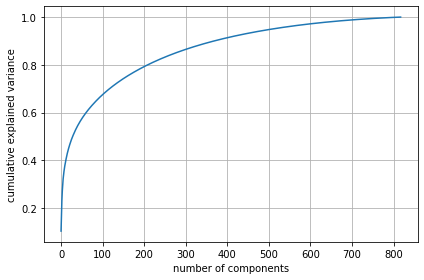

In [17]:
X,y, IDs = dfToNumpy(concat_df)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid(b=True)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig('pca_explained_variance.png')
plt.tight_layout()
files.download('pca_explained_variance.png')

In [0]:
# preprocess dataset, split into training and test part
X,y,ID = dfToNumpy(concat_df)
X_train, y_train, X_test, y_test, IDs_train, IDs_test  = split_TrainTest(concat_df, motifs_dict, 'p77y27', 'abcdef')
y_label = np.copy(y).astype(str)
y_label[y_label == '0'] = 'UD'
y_label[y_label == '1'] = 'FD'

In [0]:
def comparePCA(algo, n):
    reduction = PCA(n_components=n)
    x_train_reduced = reduction.fit_transform(X_train)
    x_test_reduced = reduction.transform(X_test)
    
    classifier2 = algo
    classifier2.fit(X_train, y_train)
    y_pred2 = classifier2.predict(X_test)
    acc = accuracy_score(y_test,y_pred2)
    

    classifier = algo
    classifier.fit(x_train_reduced, y_train)
    y_pred = classifier.predict(x_test_reduced)
    acc_PCA = accuracy_score(y_test,y_pred)

    #print("Acc with PCA= ", acc)
    #print("Acc without PCA= ", acc2)

    return acc_PCA, acc
 


In [71]:
n_components = [2,5,10,50,100,250]
pca_file = open("pca_comp.csv",'a+')
print("Test set,Classifier,Accuracy w/o PCA,Accuracy w/ PCA,n_components")
for n in n_components:
  for test_bird in motifs_dict:
    for test_motif in motifs_dict[test_bird]:
      X_train, y_train, X_test, y_test, IDs_train, IDs_test  = split_TrainTest(concat_df, motifs_dict, test_bird,test_motif)
      #print("Classifier: SVC")
      acc_PCA, acc = comparePCA(SVC(C=0.001,kernel='linear'),n)
      pca_file.write(''+str(test_bird)+'_'+str(test_motif)+',SVC,'+str(acc)+','+str(acc_PCA)+','+str(n))
      #print("Classifier: Logistic Regression")
      acc_PCA, acc = comparePCA(LogisticRegression(C=0.001, max_iter=100, multi_class='ovr', solver='lbfgs'),n)
      pca_file.write(''+str(test_bird)+'_'+str(test_motif)+',Logistic Regression,'+str(acc)+','+str(acc_PCA)+','+str(n))

pca_file.close()


Test set,Classifier,Accuracy w/o PCA,Accuracy w/ PCA,n_components


## Plotting boundary lines 

> For PCA with n=2 components

In [0]:
def BoundaryLine(algo, algo_name):
    reduction = PCA(n_components=2)
    x_train_reduced = reduction.fit_transform(X_train)
    x_test_reduced = reduction.transform(X_test)
    
    

    classifier = algo
    classifier.fit(x_train_reduced, y_train)
    y_pred = classifier.predict(x_test_reduced)
    acc = accuracy_score(y_test,y_pred)
    print("acc=",acc)
    #Boundary Line
    #X_set, y_set = np.concatenate([x_train_reduced, x_test_reduced], axis = 0), np.concatenate([y_train, y_test], axis = 0)
    X_set, y_set= X_test, y_test
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.5, cmap = ListedColormap(('orange', 'blue')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('orange', 'blue'))(i), label = j)
    plt.title('{} Boundary Line with PCA' .format(algo_name))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.xticks(fontsize = 3)
    plt.yticks(fontsize = 3)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


acc= 0.7794117647058824


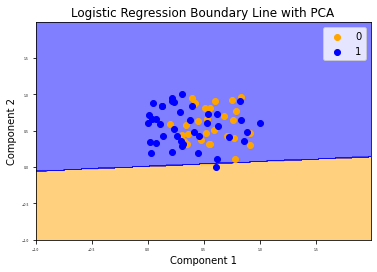

In [47]:
fig = plt.figure()


#Logistic Regression   
ax.set_title('Linear PCA')
ax.set_ylabel('Logistic \n Regression', rotation = 0, labelpad=30, fontsize = 10)
BoundaryLine(LogisticRegression(C=0.001, max_iter=100, multi_class='ovr', solver='lbfgs'), "Logistic Regression")
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


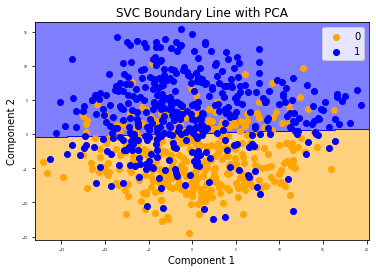

In [43]:
fig = plt.figure()

# SVC
ax.set_title('Linear PCA')
ax.set_ylabel('SVC', rotation = 0, labelpad=30, fontsize = 10)
BoundaryLine(SVC(C=0.001,kernel='linear'), "SVC")

Acc with PCA=  0.7794117647058824
Acc without PCA=  0.8088235294117647


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


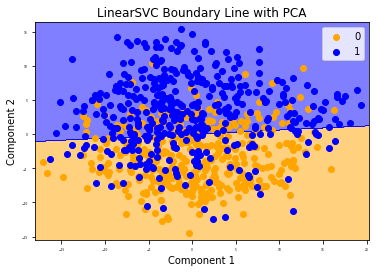

In [57]:
fig = plt.figure()

#Linear SVC   
ax.set_title('Linear PCA')
ax.set_ylabel('LinearSVC', rotation = 0, labelpad=30, fontsize = 10)
BoundaryLine(LinearSVC(C=0.001,max_iter=100), "LinearSVC")